In [1]:
import numpy as np
import scipy

# import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
    
from datetime import datetime
import time

In [16]:
class ExpMethod:
    
    def __init__(self, v_0, R, M, tau, N):
        self.v_0 = v_0
        self.R = R
        self.M = M
        self.tau = tau
        self.N = N
        
        self.x = np.linspace(-R, R, M+1)
        self.delta = self.x[1] - self.x[0]
        
        # matrices
        diag_T = 2/self.delta**2 * np.ones(M-1)
        subdiag_T = -1/self.delta**2 * np.ones(M-2)
        diags_T = [subdiag_T, diag_T, subdiag_T]
        T = scipy.sparse.diags(diags_T,[-1,0,1]).toarray()
        
        I = scipy.sparse.eye(self.M-1).toarray()
        expT_pade = (I + T * self.tau / 2) @ scipy.linalg.inv(I - T * self.tau / 2)
        
        diag_V = self.v_0*np.exp(-self.x[1:-1]**2)
        diag_expV = np.exp(diag_V * self.tau / 2)
        diags_expV = [diag_expV]
        expV = scipy.sparse.diags(diags_expV,[0]).toarray()
        
        self.A = scipy.linalg.fractional_matrix_power(expV @ expT_pade @ expV, N)
    
    def arnoldi_iteration(self, A, b, n: int):
        """Computes a basis of the (n + 1)-Krylov subspace of A: the space
        spanned by {b, Ab, ..., A^n b}.
    
        Arguments
          A: m × m array
          b: initial vector (length m)
          n: dimension of Krylov subspace, must be >= 1
        
        Returns
          Q: m x (n + 1) array, the columns are an orthonormal basis of the
            Krylov subspace.
          h: (n + 1) x n array, A on basis Q. It is upper Hessenberg.  
        """
        eps = 1e-12
        h = np.zeros((n+1,n))
        Q = np.zeros((A.shape[0],n+1))
         # Normalize the input vector
        Q[:,0] =b/np.linalg.norm(b,2)   # Use it as the first Krylov vector
        for k in range(1,n+1):
            v = np.dot(A,Q[:,k-1])  # Generate a new candidate vector
            for j in range(k):  # Subtract the projections on previous vectors
                h[j,k-1] = np.dot(Q[:,j].T, v)
                v = v - h[j,k-1] * Q[:,j]
            h[k,k-1] = np.linalg.norm(v,2)
            if h[k,k-1] > eps:  # Add the produced vector to the list, unless
                Q[:,k] = v/h[k,k-1]
            else:  # If that happens, stop iterating.
                return Q, h
        return Q, h
    
#     def many_E_arnoldi_iteration(self, n):
#         Q, h = self.arnoldi_iteration(self.A, np.random.rand(self.M-1), n)
#         eigvals = np.sort(np.real(scipy.linalg.eigvals(h[:-1])))
#         eigvals = np.log(eigvals) / (self.tau * self.N)
#         return eigvals[(eigvals>self.v_0)*(eigvals<0.0)]
    
    def many_E_arnoldi_iteration(self, k, return_eigenvectors=False):
        if return_eigenvectors:
            w, v = scipy.sparse.linalg.eigs(self.A, k=k, return_eigenvectors=return_eigenvectors)
            residual = np.zeros(k)
        
            for i in range(k):
                residual[i] = scipy.linalg.norm((self.A - w[i] * scipy.sparse.eye(self.M-1).toarray()) @ v[:,i])
           
            w = np.log(np.real(w)) / (self.tau * self.N)
            return w[(w>self.v_0)*(w<0.0)], residual[(w>self.v_0)*(w<0.0)]
        else:
            w = scipy.sparse.linalg.eigs(self.A, k=k, return_eigenvectors=return_eigenvectors)
            w = np.log(np.real(w)) / (self.tau * self.N)
            return w[(w>self.v_0)*(w<0.0)]

In [17]:
# constants
v_0 = -5.0
R = 6.0
M = 1000
tau = -1e-5
N = 10

e = ExpMethod(v_0, R, M, tau, N)

In [18]:
e.many_E_arnoldi_iteration(5)

array([-0.40420461, -3.14035799])

In [20]:
v_0 = -5.0
R = 6.0
m = np.linspace(100, 2000, 10, dtype=int)
tau = -1e-3
N = 10
t = [None] * len(m)

print('m   t   w')

for i in range(len(m)):
    start_time = datetime.now()
    
    e = ExpMethod(v_0, R, m[i], tau, N)
    w = e.many_E_arnoldi_iteration(50)
    
    t[i] = datetime.now() - start_time
    
    print(m[i], t[i], w)   

m   t   w
100 0:00:00.143570 [-0.40801283 -3.14274577]
311 0:00:00.222790 [-0.40456075 -3.14058251]
522 0:00:00.532119 [-0.4043058  -3.14042208]
733 0:00:01.836450 [-0.4042367  -3.14037858]
944 0:00:03.258566 [-0.40420847 -3.1403608 ]
1155 0:00:05.815777 [-0.40419424 -3.14035185]
1366 0:00:10.951525 [-0.40418608 -3.14034671]
1577 0:00:13.206430 [-0.40418097 -3.14034349]
1788 0:00:17.315830 [-0.40417756 -3.14034134]
2000 0:00:26.708996 [-0.40417516 -3.14033983]


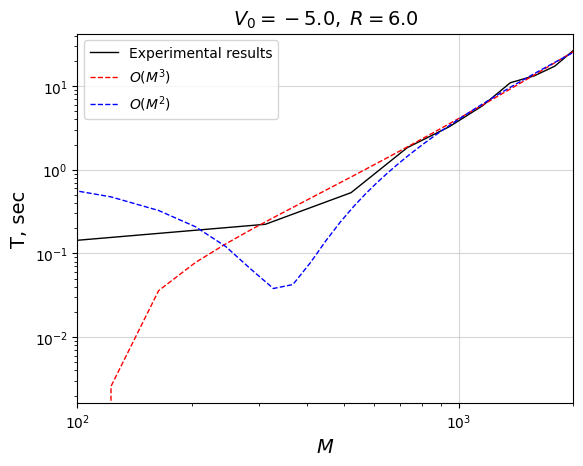

In [29]:
tt = [t_.seconds+t_.microseconds*1e-6 for t_ in t]

p3 = np.poly1d(np.polyfit(m, tt, 3))
p2 = np.poly1d(np.polyfit(m, tt, 2))
p1 = np.poly1d(np.polyfit(m, tt, 1))

mm = np.linspace(0, m[-1])

plt.plot(m, tt, color='black', linewidth=1, label='Experimental results')

plt.plot(mm, p3(mm), color='red', linewidth=1, linestyle='--', label=r'$O(M^3)$')
plt.plot(mm, p2(mm), color='blue', linewidth=1, linestyle='--', label=r'$O(M^2)$')
# plt.plot(mm, p1(mm), color='green', linewidth=1, linestyle='--', label=r'$O(M)$')

plt.xlabel(r'$M$', fontsize=14)
plt.ylabel('T, sec', fontsize=14)

plt.title(fr'$V_0={v_0},\; R={R}$', fontsize=14)

plt.xlim(m[0], m[-1])
# plt.ylim(0, None)
plt.yscale('log')
plt.xscale('log')

plt.grid(alpha=0.5)
plt.legend()

plt.savefig(f'figures/T_vs_M_{e.v_0}.png', bbox_inches='tight', dpi=250)

In [114]:
v_0 = -5.0
R = 6.0
M = 1000
N = 100

tau_ = -np.logspace(-2, -10, 8)

E = []
residual = []

for i in range(len(tau_)):
    print(i)
    e = ExpMethod(v_0, R, M, tau_[i], N)
    w, r = e.many_E_arnoldi_iterantion(10, True)
    E += [w[:2]]
    residual += [r[:2]]

0
1
2
3
4
5
6
7


In [115]:
E = np.array(E)
residual = np.array(residual)
E.shape, residual.shape

((8, 2), (8, 2))

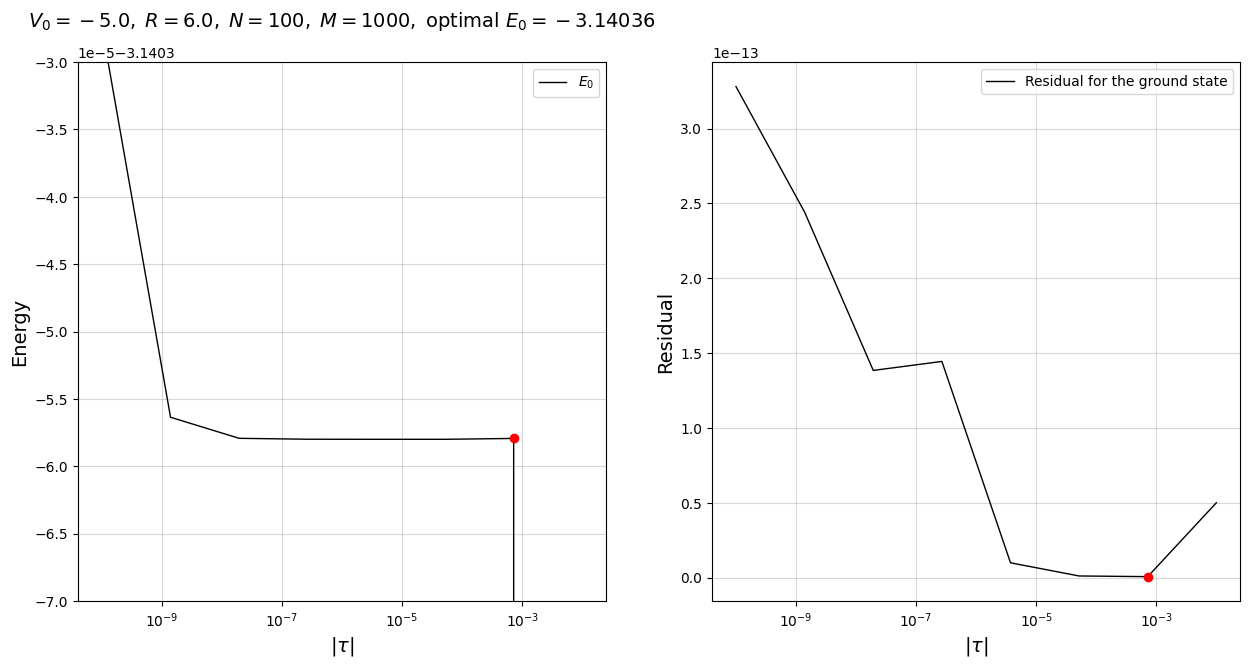

In [127]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

ax[0].plot(abs(tau_), E[:,0], color='black', linewidth=1, label=r'$E_0$')
ax[1].plot(abs(tau_),residual[:,0], color='black', linewidth=1, label=r'Residual for the ground state')

ax[0].plot(abs(tau_[residual[:,0].argmin()]), E[:,0][residual[:,0].argmin()], marker='o', color='red')
ax[1].plot(abs(tau_[residual[:,0].argmin()]), residual[:,0].min(), marker='o', color='red')

# ax[0].axhline(y=0.0, color='black', linewidth=1, linestyle='--', label=r'Reference $E_0$')

ax[0].set_xlabel(r'$|\tau|$', fontsize=14)
ax[0].set_ylabel(r'Energy', fontsize=14)

ax[0].set_title(fr'$V_0={v_0},\; R={R},\; N={N},\; M={M},\;$optimal $E_0={E[:,0][residual[:,0].argmin()]:0.5f}$', fontsize=14, y=1.05)

ax[0].set_ylim(-7e-5-3.1403,-3e-5-3.1403)
ax[0].set_xscale('log')

ax[0].grid(alpha=0.5)
ax[0].legend()

ax[1].set_xlabel(r'$|\tau|$', fontsize=14)
ax[1].set_ylabel(r'Residual', fontsize=14)

ax[1].set_xscale('log')

ax[1].grid(alpha=0.5)
ax[1].legend()

plt.savefig(f'figures/E_vs_tau_{e.v_0}_e0.png', bbox_inches='tight')

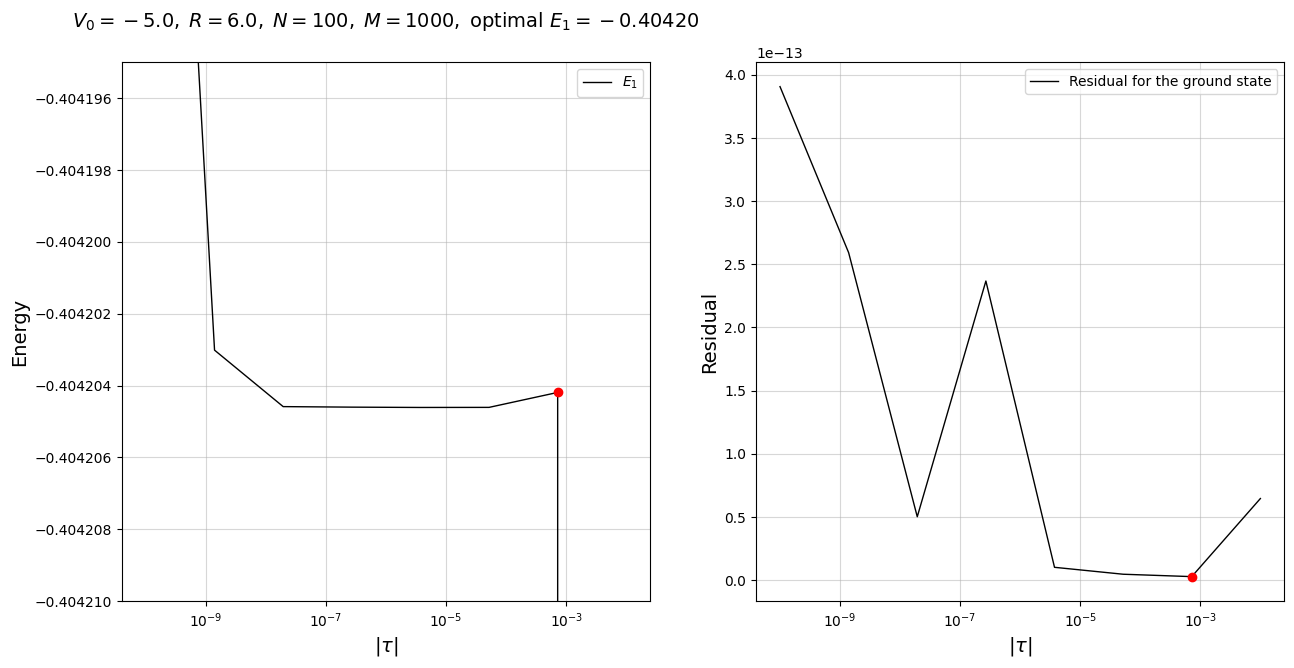

In [135]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

ax[0].plot(abs(tau_), E[:,1], color='black', linewidth=1, label=r'$E_1$')
ax[1].plot(abs(tau_),residual[:,1], color='black', linewidth=1, label=r'Residual for the ground state')

ax[0].plot(abs(tau_[residual[:,1].argmin()]), E[:,1][residual[:,1].argmin()], marker='o', color='red')
ax[1].plot(abs(tau_[residual[:,1].argmin()]), residual[:,1].min(), marker='o', color='red')

ax[0].set_ylim(-0.40421, -0.404195)

ax[0].set_xlabel(r'$|\tau|$', fontsize=14)
ax[0].set_ylabel(r'Energy', fontsize=14)

ax[0].set_title(fr'$V_0={v_0},\; R={R},\; N={N},\; M={M},\;$optimal $E_1={E[:,1][residual[:,1].argmin()]:0.5f}$', fontsize=14, y=1.05)

ax[0].set_xscale('log')

ax[0].grid(alpha=0.5)
ax[0].legend()

ax[1].set_xlabel(r'$|\tau|$', fontsize=14)
ax[1].set_ylabel(r'Residual', fontsize=14)

ax[1].set_xscale('log')

ax[1].grid(alpha=0.5)
ax[1].legend()

plt.savefig(f'figures/E_vs_tau_{e.v_0}_e1.png', bbox_inches='tight')